# 📊 Customer Churn Analysis with BigQuery & Python 🚀

## **Introduction**

In this notebook, we will analyze customer churn data using Google BigQuery and Python. The dataset contains information about customers. the varibles in the dataset are:

1. customer_id
2. credit_score 
3. country
4. gender
5. age
6. tenure
7. balance
8. products_number
9. credit_card
10. active_member
11. estimated_salary
12. churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

In this notebook we will set up the connection between kaggle and BigQuery, load the data from BigQuery, and perform some basic data analysis. We will also visualize the data using matplotlib and seaborn.

## **Import Libraries**

For this first part we will use `os` to set the environment variables, `pandas` to manipulate the data and `google.cloud` to connect to BigQuery.

In [1]:
import os
import pandas as pd
from google.cloud import bigquery

## Setting up Service Account Credentials

For this project, I wanted to learn how to manage kaggle datasets using bigQuery.Turns out GCP provides service acounts, which can be used to access BigQuery datasets.

First we have to set the environment variables for the service account credentials.

I decided to do this by downloading the key directly from GCP, and saving it on the current codespaces virtual machine I'm using for development. For this process to be secure, I added the folder where this key is stored to the .gitignore file, so it won't be uploaded to GitHub. 

Then, let's set an environment variable where the path to the .json file is saved.


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/ABCBankChurnRate/.config/sa_credentials.json"

## Initializing BigQuery Client

Now, a variable called `client` which is an instance of the `google.cloud.bigquery.Client` class, has it's own methods and attributes. One of it's attributes is `.project`. Printing it will confirm that the client is authenticated, and connected to the GCP project I set up for this data set.

In [3]:
client = bigquery.Client()
print(client.project)

kagglebigquerybankchurn


This `client` object will allow us to perform operations like:

- Running SQL queries on BigQuery Datasets (My main goal on pursuing this specific path)
- Creating datasets and tables (this will be needed to fetch)
- fetch query results as `pandas` DataFrames.

## Fetching Dataset From Kaggle


Now, this dataset is avaliable at kaggle [here](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset). I selected this dataset because the dependent variable is categorical. From my background in analytical chemistry I'm used to work with continuous dependent variables. Then, this is a great oportunity for me to learn how these different systems behave.

let's then import the `kaggle API` first:

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
import glob

`glob` will be used to handle the datasets temporarily. I think datasets should not be saved in repositories for efficiency, so we well see below how to address this.

Now, we will temporarily download the dataset using my kaggle credentials, which i have saved in a .env file that is not commited so you cannot see them 😜:

In [5]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set Kaggle credentials from environment variables
if 'KAGGLE_USERNAME' not in os.environ or 'KAGGLE_KEY' not in os.environ:
	raise EnvironmentError("Kaggle credentials not found in environment variables")

in the code above I added a flow control structure that checks if the credentials are set in the environment, if not an error is raised.

Now, let's actually use Kaggle's API to download the dataset.

In [6]:
api = KaggleApi()
api.authenticate()

if no error is raised in the  code above, we successfully authenticated and can access the dataset. Now let's tell python wher it is and where it will be downloaded: 

In [7]:
dataset_name = "gauravtopre/bank-customer-churn-dataset"  # the categorical dependent variable dataset I described to you earlier
download_path = "/tmp"  # Temporary location, not inside this repo

Next we will actually downolad the dataset, into the temporary folder. Once that's done, `glob` will check if it actually is downloaded. Since we know it's a single file, printing the first element `csv_files[0]` is enough.

In [8]:
# Download dataset (ZIP file)
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# Find the downloaded CSV file
csv_files = glob.glob(f"{download_path}/*.csv")
assert len(csv_files) > 0, "No CSV files found. Check dataset name."
csv_file_path = csv_files[0]  

print(f"✅ Dataset downloaded: {csv_file_path}")

Dataset URL: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset
✅ Dataset downloaded: /tmp/Bank Customer Churn Prediction.csv


## Uploading dataset to bigquery


Ok, we have the dataset saved in that `/tmp` folder, ready to be uploaded to bigquery. 

In the Google Data Analytics Professional certificate, I had the chance to work with bigquery and I found it amazing. From those times I remember each table is within a dataset, and it should have it's own unique identifier. We will need that now, so let's set it up.

In the following code we will define the `dataset_id` and `table_id` our kaggle dataset will have inside bigquery, and we will use to run our queries.

In [9]:
project_id = client.project # This is already defined by the service account
dataset_id = f"{project_id}.churn_analysis"
table_id = "Kaggle_churn"
full_table_id = f"{dataset_id}.{table_id}"

Now that we have defined that unique identifier for the data table, and the dataset whithin it will be saved, we can go ahead and create the dataset:

In [10]:
client.create_dataset(dataset_id, exists_ok=True)

Dataset(DatasetReference('kagglebigquerybankchurn', 'churn_analysis'))


Now check if there is any tables within the dataset. I think there should not because we have not used the kaggle API yet:

In [11]:
tables = {table.table_id for table in client.list_tables(dataset_id)}
print(tables)

{'Kaggle_churn'}


Ok this set comprehension (which I find tremendously efficient) loops trough all the tables within the dataset named `dataset_id`. indeed since right now we haven't used the kaggle functions there is no table yet. Let's get to that.

ok the next chunk of code will upload the dataset to bigquery. 

this process need several configurations to be set, so we are going to save these in the `job_config` variable as follows:

In [12]:
job_config = bigquery.LoadJobConfig(
    autodetect = True,
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1
)

that `job_config` variable will tell the `load_table_from_file` function which schema to use, and what configuration the table load should have.

I've been trough this process many times inside the bigquery site, and every time I felt like selecting options from drop down menus, and pushing buttons was not as reproducible as I would like it to be. Now I'm glad it can be written down in code and anyone can use this for their needs (assuming someone besides me reads this 🤣). 

Now let's do the upload:

In [13]:
with open(csv_file_path, "rb") as source_file:
        job = client.load_table_from_file(source_file, full_table_id, job_config=job_config)

In [14]:
job.result()

LoadJob<project=kagglebigquerybankchurn, location=US, id=d1ecfbb0-f46f-412e-af46-06830fc608fc>

OK! finally, we have the dataset in biquery and we can query it so it gives us insight on how we should address the data, and which model we could use to predict the bank churn. Let's do a visualization of all variables really quick:

- To do this, first I want to see it with my own eyes, How a result of a SQL query can be shown in a notebook (hyped)

In [15]:
## let's define a query that is analogue to the head function

query = """

SELECT * 
FROM `kagglebigquerybankchurn.churn_analysis.Kaggle_churn`
LIMIT 10

""" 
# Then, run the query using the query method of the client instance:

query_job = client.query(query)
df = query_job.to_dataframe()
# and then actually see the table (can't wait)

df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15570086,684,Germany,Male,18,9,90544.00,1,0,1,4777.23,0
1,15570086,684,Germany,Male,18,9,90544.00,1,0,1,4777.23,0
2,15796231,681,France,Female,18,1,98894.39,1,1,1,9596.40,0
3,15796231,681,France,Female,18,1,98894.39,1,1,1,9596.40,0
4,15665521,642,Germany,Male,18,5,111183.53,2,0,1,10063.75,0


excellent just wonderful, gracious. Now I can practice my SQL skills right here in a python notebook. isn't that neat?

## Exploratory data analysis

now let's see how the variables are related to the churn rate. For that, we will create the main dataframe again, but will not limit the amount of rows to ten, this dataframe will be named `full_df`


In [16]:
full_query = """
SELECT *
FROM `kagglebigquerybankchurn.churn_analysis.Kaggle_churn`
"""
full_query_job = client.query(full_query)
full_df = full_query_job.to_dataframe()


let's really quick check if there are any missing values:

In [17]:
full_df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Now we can check information about the variables with the `.info` and `.describe` functions as follows:

In [18]:
full_df.describe()


,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,60000.0,60000.0,60000.0,60000.0,60000.000000,60000.0,60000.0,60000.0,60000.000000,60000.0
mean,15690940.5694,650.5288,38.9218,5.0128,76485.889288,1.5302,0.7055,0.5151,100090.239881,0.2037
std,71933.188669,96.649271,10.487369,2.892054,62394.805213,0.58163,0.455821,0.499776,57508.096457,0.402752
min,15565701.0,350.0,18.0,0.0,0.000000,1.0,0.0,0.0,11.580000,0.0
25%,15628528.25,584.0,32.0,3.0,0.000000,1.0,0.0,0.0,51002.110000,0.0
50%,15690738.0,652.0,37.0,5.0,97198.540000,1.0,1.0,1.0,100193.915000,0.0
75%,15753233.75,718.0,44.0,7.0,127644.240000,2.0,1.0,1.0,149388.247500,0.0
max,15815690.0,850.0,92.0,10.0,250898.090000,4.0,1.0,1.0,199992.480000,1.0


Thanks to this summary table, we can identify that there is two groups of variables:

### Continuous variables:
- Credit_score
- Age
- Estimated_salary
- Balance

Let's examine these variables further by visualizing their distributions:

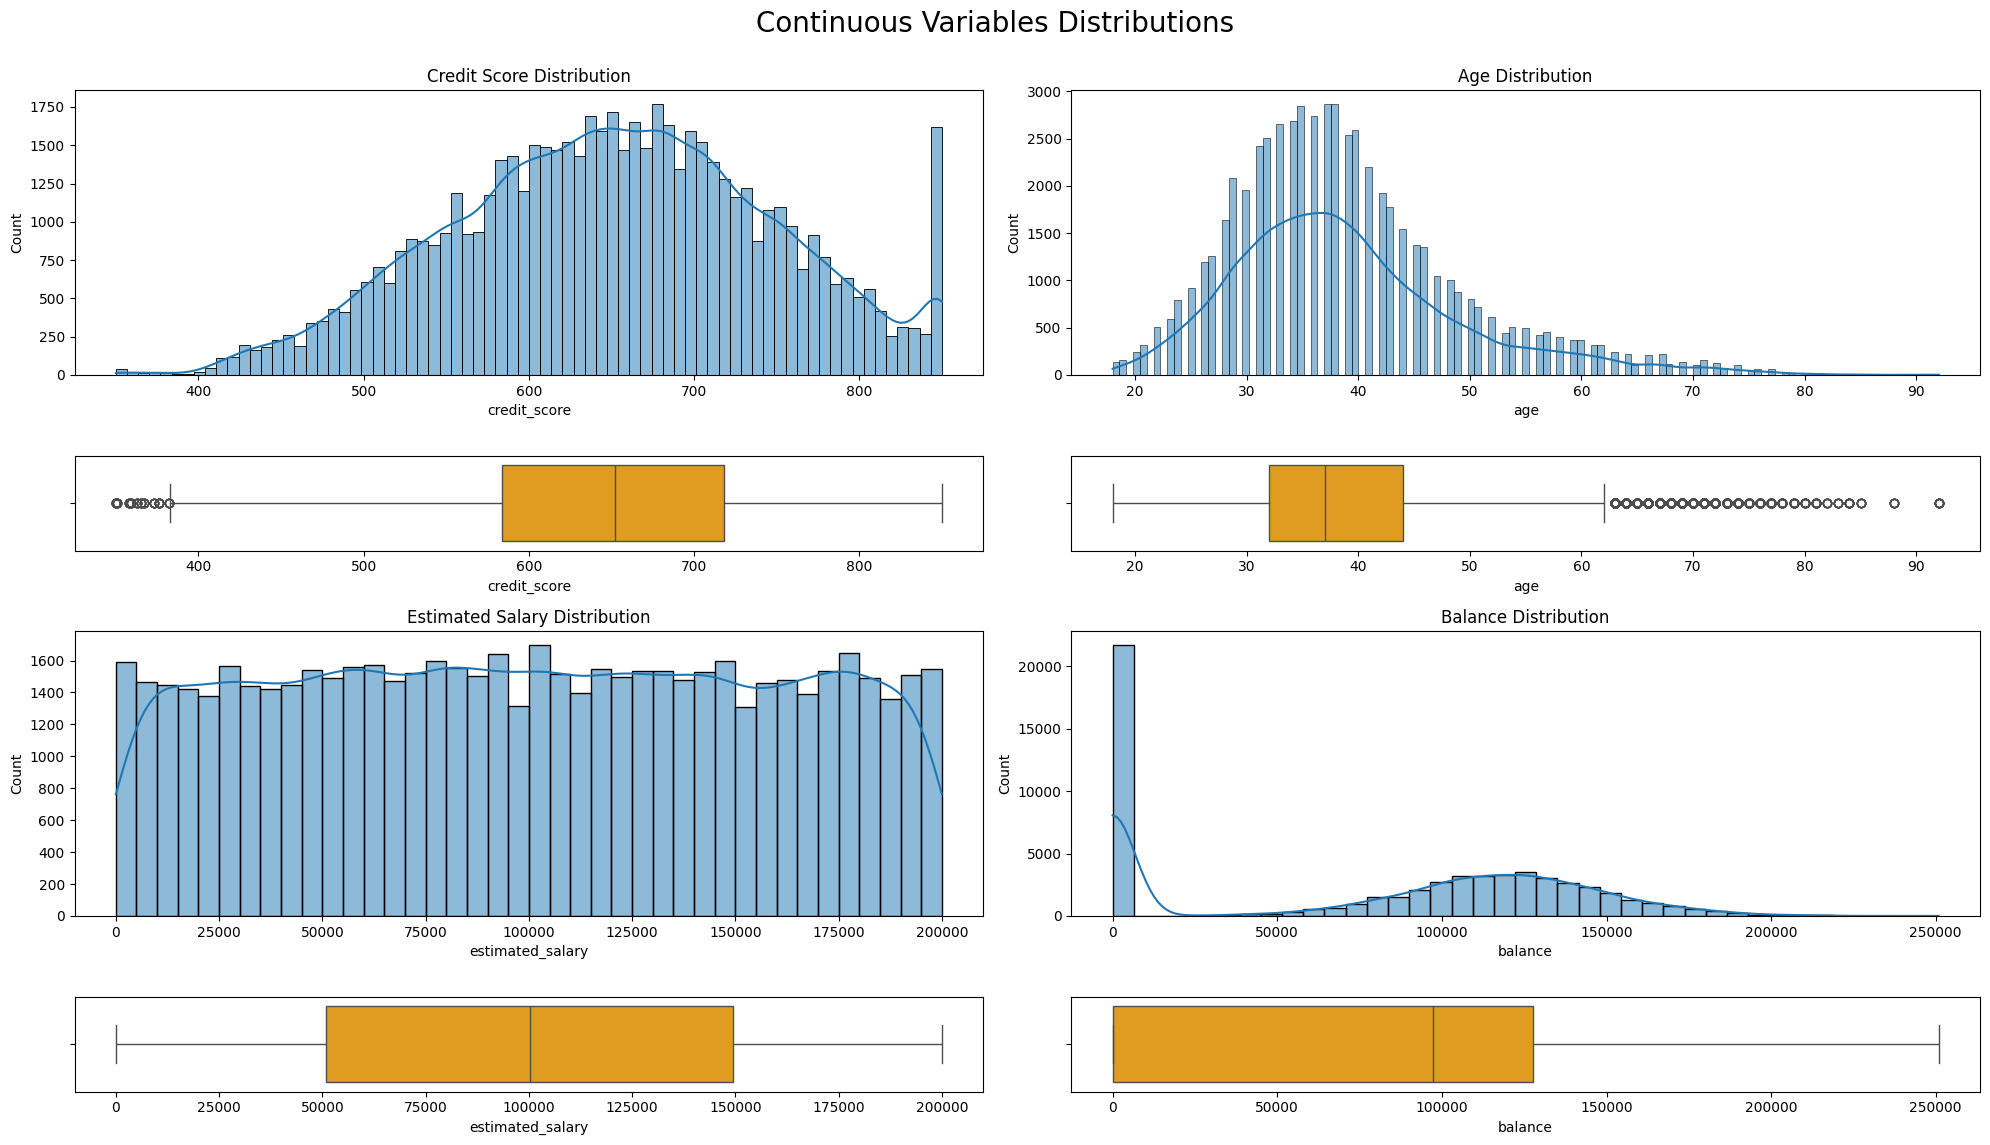

In [19]:
# setting the canvas for four plots (2 rows, 4 columns)
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a larger figure with a grid of 4x2 subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 2, height_ratios=[3, 1, 3, 1])

# Set the figure title
fig.suptitle('Continuous Variables Distributions', fontsize=20, y=0.95)

# Define variables and titles for the plots
variables = ['credit_score', 'age', 'estimated_salary', 'balance']
titles = ['Credit Score Distribution', 'Age Distribution', 'Estimated Salary Distribution', 'Balance Distribution']

# Loop through variables and plot
for i, (var, title) in enumerate(zip(variables, titles)):
    # Histogram
    ax_hist = fig.add_subplot(gs[i // 2 * 2, i % 2])
    sns.histplot(data=full_df, x=var, kde=True, ax=ax_hist)
    ax_hist.set_title(title)
    
    # Boxplot
    ax_box = fig.add_subplot(gs[i // 2 * 2 + 1, i % 2])
    sns.boxplot(data=full_df, x=var, color='orange', ax=ax_box)
    ax_box.set_title('')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


Thanks to these visualizations we can comment some things about these four continuous variables, to consider in the modelling stage:

1. **Credit Score**
    - Is normally distributed, good for modelling, and also complies with the assumptions of most statistical tests.
    - Supports the assumptions of most hypothesis tests (that's great, just What I Learned in the regression course of the *Google Advanced Data Analytics Professional Certificate*).

    **References**:
    - Hosmer Jr, D. W., et al. (2013). ["Applied Logistic Regression"](https://books.google.com.co/books?hl=en&lr=&id=bRoxQBIZRd4C&oi=fnd&pg=PR13&dq=Hosmer+Jr,+D.+W.,+et+al.+(2013).+%22Applied+Logistic+Regression%22+-+Discusses+normality+assumptions&ots=kM4Otl6Sb5&sig=9Q0GI1KojiWmqTd861azWkxeWm8&redir_esc=y#v=onepage&q&f=false) - Discusses normality assumptions.
    - Altman, N., & Krzywinski, M. (2016). ["Points of Significance: Analyzing outliers"](https://go.gale.com/ps/i.do?id=GALE%7CA461963379&sid=googleScholar&v=2.1&it=r&linkaccess=abs&issn=15487091&p=AONE&sw=w&userGroupName=anon%7E5d49140c&aty=open-web-entry) Nature Methods.

2. **Age (normal with a right tail)**
    - Age distributions are commonly found to have a right-skewed distribution (this makes sense to me because older people tend to die and then the amount of older people decreases).
    - May require log transformation for a linear model.

    **References**:
    - Cox, D. R., & Snell, E. J. (1989). ["Analysis of Binary Data"](https://www.taylorfrancis.com/books/mono/10.1201/9781315137391/analysis-binary-data-cox) (2nd ed.). Chapman and Hall/CRC.
    - Faraway, J. J. (2016). ["Extending the Linear Model with R"](https://www.google.com.co/books/edition/Extending_the_Linear_Model_with_R/XAzYCwAAQBAJ?hl=en&gbpv=1&dq=Faraway,+J.+J.+(2016).+%22Extending+the+Linear+Model+with+R%22+(2nd+ed.),+Chapman+and+Hall/CRC&pg=PR2&printsec=frontcover) (2nd ed.), Chapman and Hall/CRC.

3. **Estimated Salary (Uniform)**
    - Uniform distribution. This is weird for me, and checking in literature uniform distributions indeed are due to:
        - Data preprocessing/binning could work to enhance its usability.
        - Potential sampling bias.

    **References**:
    - Cohen, J., et al. (2003). "Applied Multiple Regression/Correlation Analysis."
    - Friedman, J., et al. (2001). "The Elements of Statistical Learning" - Discussion of feature distributions.

4. **Balance (Normal, with many values around zero)**
    - Well, it seems like in financial data this is normal, and I understand, many people will have accounts with zero balance.
    - Statistical implications:
        - Need for specialized modeling approaches.
        - Consider two-part models (zero vs non-zero).
        - May require transformation for non-zero values.

    **References**:

    - Min, Y., & Agresti, A. (2002). "Modeling nonnegative data with clumping at zero: A survey." Journal of the Iranian Statistical Society, 1(1-2), 7-33.


    - Fletcher, D., & Dixon, P. M. (2012). "Modelling data with excess zeros and measurement error: Application to evaluating relationships between abundances of multiple species." Biometrics, 68(1), 270-278.


    - Tu, W. (2006). "Zero-Inflated Data." Encyclopedia of Environmetrics, 6.




As a summary, what we can do with these variables is: 
- **Credit Score:** Use as-is in logistic regression
- **Age:** Consider log transformation
- **Salary:** Consider binning or categorical transformation
- **Balance:** Create binary flag for zero values

Before we move on to categorical variables, I want to see how the dependent variable, churn, is related to these four variables in a similar fashion, son now we will again draw four plots in the same canvas, but this time the will be scatter plots instead of histograms, keeping the boxplot of the independent variable at the bottom:

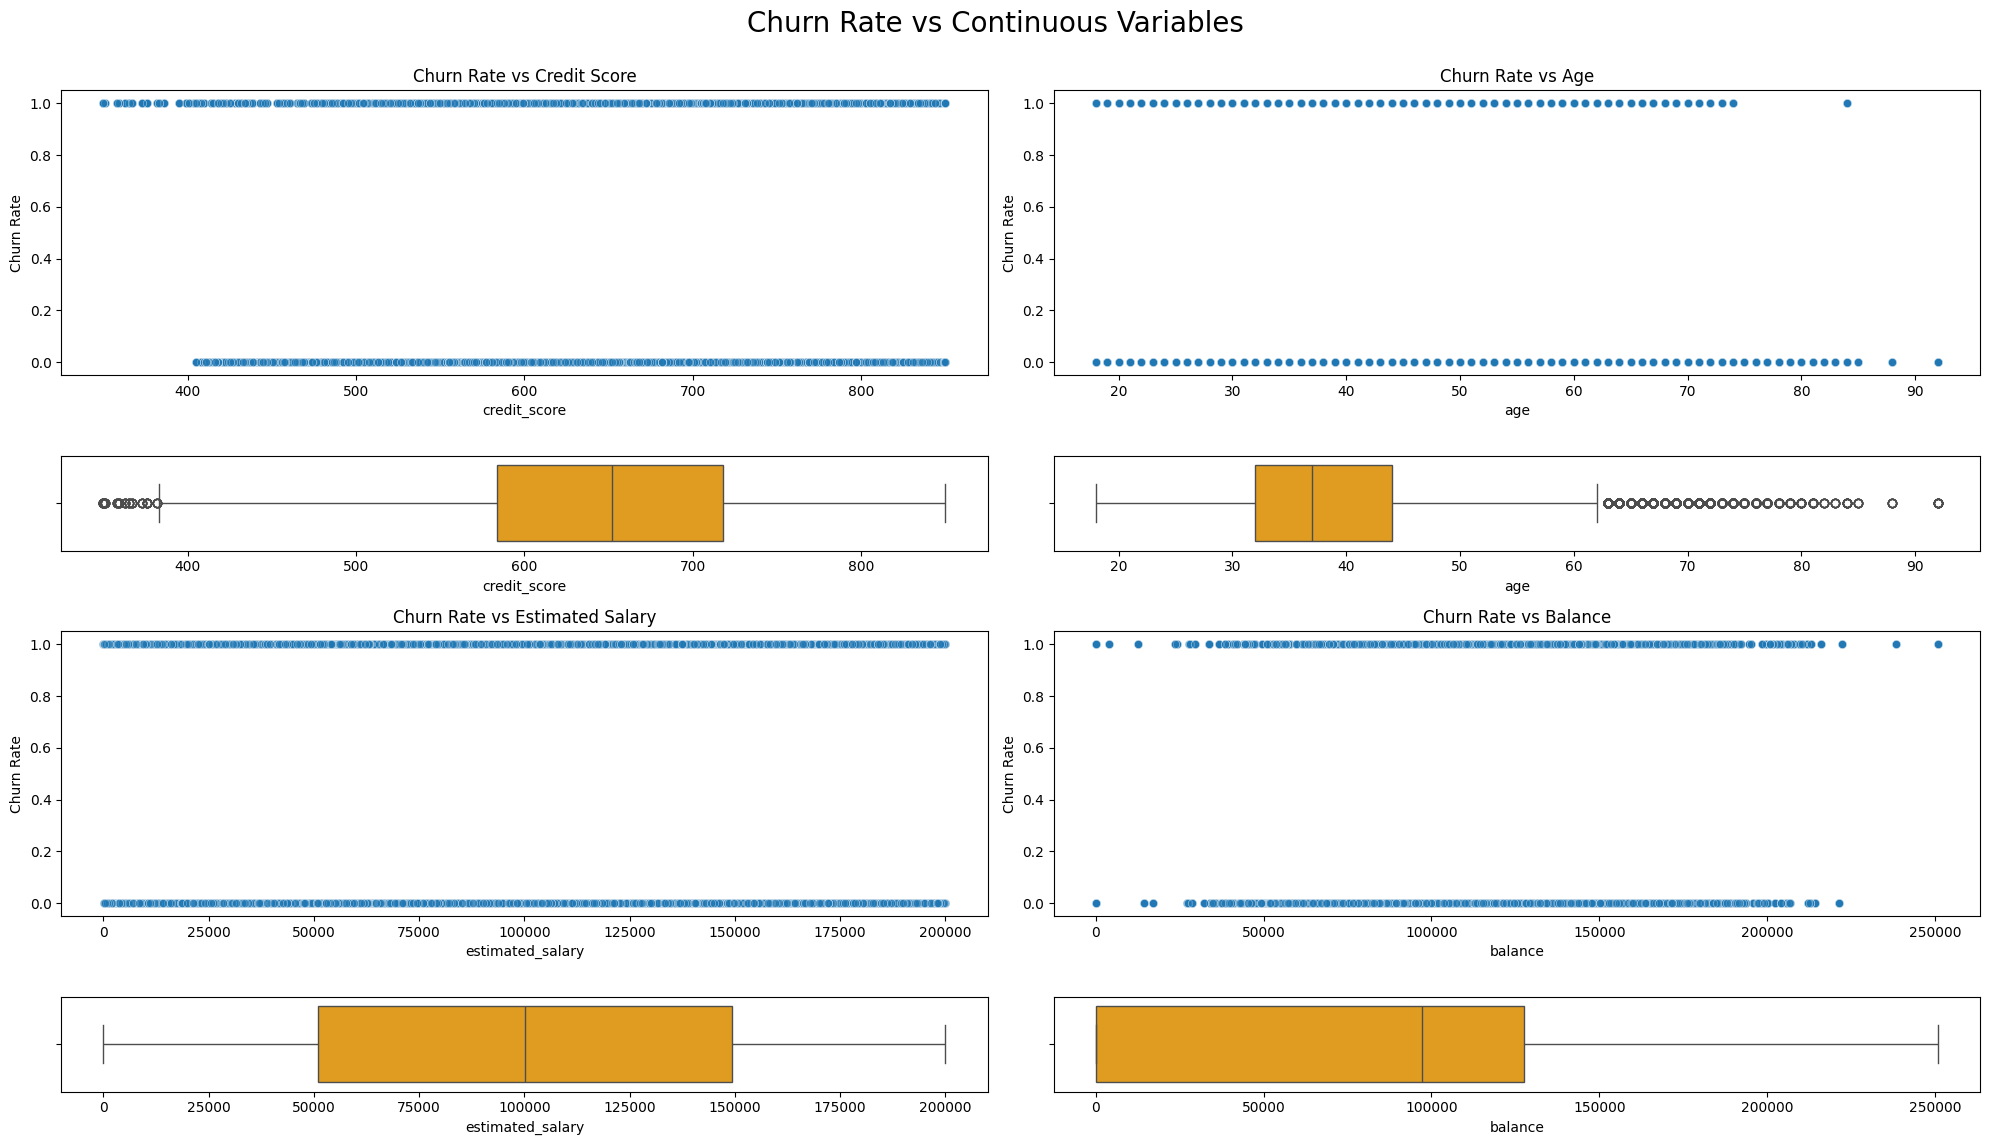

In [20]:
# setting the canvas for four plots (2 rows, 4 columns)
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a larger figure with a grid of 4x2 subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 2, height_ratios=[3, 1, 3, 1])

# Set the figure title
fig.suptitle('Churn Rate vs Continuous Variables', fontsize=20, y=0.95)

# Define variables and titles for the plots
variables = ['credit_score', 'age', 'estimated_salary', 'balance']
titles = ['Churn Rate vs Credit Score', 'Churn Rate vs Age', 'Churn Rate vs Estimated Salary', 'Churn Rate vs Balance']

# Loop through variables and plot
for i, (var, title) in enumerate(zip(variables, titles)):
    # Scatterplot
    ax_scatter = fig.add_subplot(gs[i // 2 * 2, i % 2])
    sns.scatterplot(data=full_df, x=var, y='churn', alpha=0.5, ax=ax_scatter)
    ax_scatter.set_title(title)
    ax_scatter.set_ylabel('Churn Rate')
    
    # Boxplot
    ax_box = fig.add_subplot(gs[i // 2 * 2 + 1, i % 2])
    sns.boxplot(data=full_df, x=var, color='orange', ax=ax_box)
    ax_box.set_title('')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


## Categorical variables: 


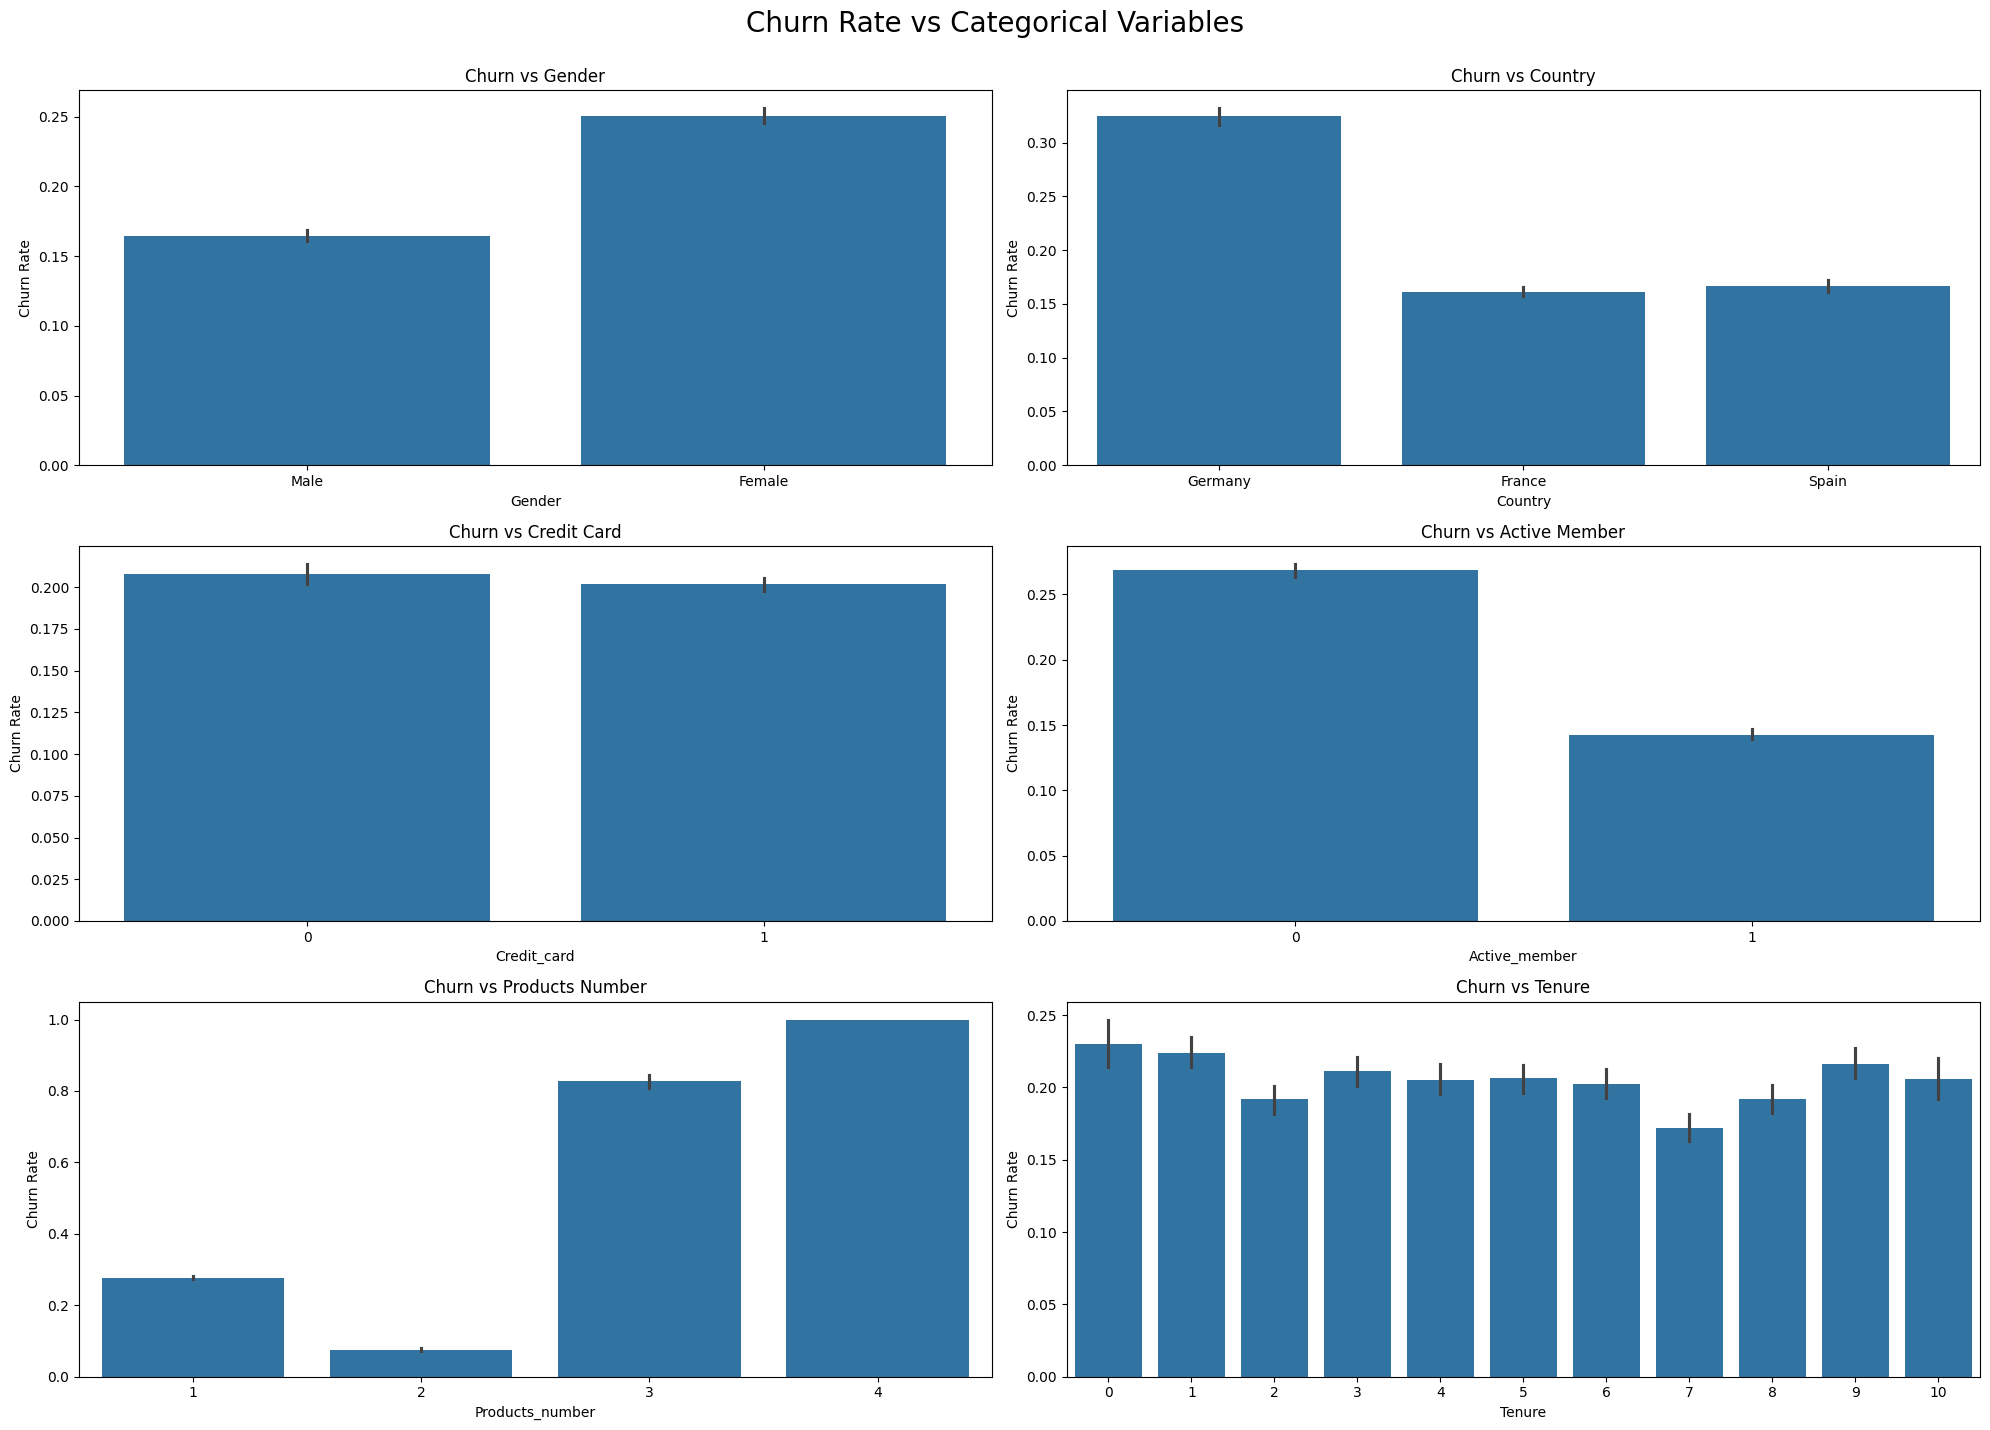

In [22]:
# Set up a larger figure with a grid of 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Set the figure title
fig.suptitle('Churn Rate vs Categorical Variables', fontsize=20, y=0.95)

# Define categorical variables and titles for the plots
cat_variables = ['gender', 'country', 'credit_card', 'active_member', 'products_number', 'tenure']
titles = ['Churn vs Gender', 'Churn vs Country', 'Churn vs Credit Card', 
          'Churn vs Active Member', 'Churn vs Products Number', 'Churn vs Tenure']

# Loop through variables and plot
for ax, var, title in zip(axes.flatten(), cat_variables, titles):
    sns.barplot(data=full_df, x=var, y='churn', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Churn Rate')
    ax.set_xlabel(var.capitalize())

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


## Analysis of Categorical Variables and Their Relationship with Churn

### Key Observations and Modeling Implications:

1. **Gender**
   - Slight imbalance in distribution (more females than males)
   - Similar churn rates between groups
   - **Modeling Decision**: Include as-is, but consider:
     - Using stratification in train-test split
     - Checking for interaction effects with other variables

2. **Country**
   - Uneven distribution (Germany ~2x France/Spain)
   - Different churn patterns across countries
   - **Modeling Decision**: 
     - Convert to dummy variables
     - Consider weighted sampling if using tree-based models
     - Important feature to keep due to visible variation in churn rates

3. **Credit Card Status**
   - Balanced distribution
   - Similar churn rates between holders/non-holders
   - **Modeling Decision**: Consider excluding due to low predictive power
     - Run feature importance check to confirm
     - Could be kept for interaction effects

4. **Active Member Status**
   - Strong predictor: 2x churn rate for inactive members
   - Clear separation between groups
   - **Modeling Decision**: 
     - Definitely keep
     - Consider as primary feature
     - Check for interactions with balance and products_number

5. **Products Number**
   - Higher churn for 3-4 products
   - Non-linear relationship with churn
   - **Modeling Decision**:
     - Keep as categorical rather than continuous
     - Consider binning into: low (1-2) and high (3-4) products
     - Test both original and binned versions

6. **Tenure**
   - Uniform distribution across groups
   - Weak relationship with churn
   - **Modeling Decision**:
     - Test both as continuous and categorical
     - Consider binning into meaningful groups (new/established customers)
     - Check for interaction with active_member
     


